# Interpretability algorithms comparison

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pdb
import cv2

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import FeatureAblation
from captum.attr import Occlusion
from captum.attr import visualization as viz

## Load Pretrained Model and Labels

In [5]:
model = models.resnet18(pretrained=True)
model = model.eval()

In [6]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-05-31 18:49:47--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.168.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.168.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/Users/gabriel.marin/.torch/models/imagenet_class_index.json.3’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.1s    

2020-05-31 18:49:47 (341 KB/s) - ‘/Users/gabriel.marin/.torch/models/imagenet_class_index.json.3’ saved [35363/35363]



In [7]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [8]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [96]:
# Select custom image
img = Image.open('killerwhale.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [97]:
# Model output
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: killer_whale ( 0.9780920147895813 )


## Gradients: Integrated Gradients

In [102]:
integrated_gradients = IntegratedGradients(model)
noise_tunnel = NoiseTunnel(integrated_gradients)

now = time.time()
attributions_ig_nt = noise_tunnel.attribute(input, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

time.time() - now

130.95046877861023

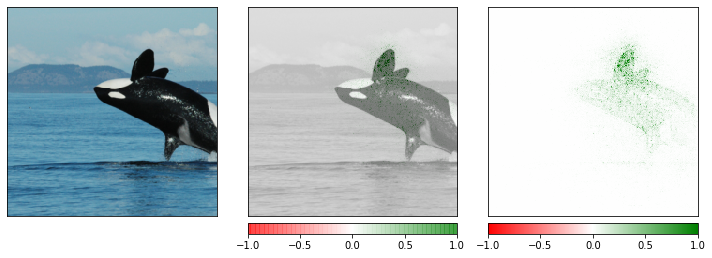

In [103]:
fig_ig, _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map", "heat_map"],
                                      ["all", "all", "all"],
                                      #cmap=default_cmap,
                                      show_colorbar=True,
                                      fig_size=(10, 10))

## Permutation: Occlusion

In [104]:
occlusion = Occlusion(model)
now = time.time()

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,65, 65),
                                       baselines=0)
time.time() - now

28.125125885009766

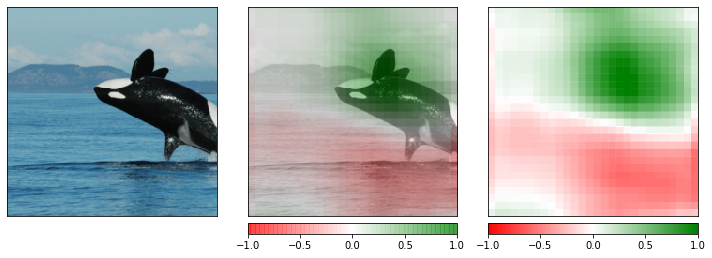

In [105]:
fig_oc, _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map", "heat_map"],
                                      ["all", "all", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2, fig_size=(10, 10),
                                     )

## CAM Attention
original code: https://github.com/zhoubolei/CAM

In [107]:
# Select custom image
IMG = 'killerwhale.jpg'
img = Image.open(IMG)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [108]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

finalconv_name = 'layer4'
model._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [109]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [110]:
logit = model(input)
h_x = F.softmax(logit, dim=1).data.squeeze()

In [111]:
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [112]:
#model prediction
idx_to_labels[str(idx[0])]

['n02071294', 'killer_whale']

In [115]:
now = time.time()
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
time.time() - now

0.9449498653411865

In [117]:
img = cv2.imread(IMG)
height, width, _ = img.shape
#create heatmap
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
#save result
cv2.imwrite('cam.jpg', result)